In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Debug
# %matplotlib notebook
# pd.options.display.max_rows = 200

In [27]:
df = pd.read_csv("depth-map-data/5-car/1503619158691071272-cloudpoint.csv", 
                 names = ['x', 'y', 'z', 'intensity', 'ring', 'rotation', 'revolution'])

df['distance'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
# np.arctan2 is element-wise arc tangent that chooses the quadrant correctly
df['rotation-angle'] = np.arctan2(df['x'], df['y']) + np.pi
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])

# img_height is number of lasers
# img_width is number of pts/number of lasers
img_height = 64
img_width = 2088

In [28]:
# Debug
# df.sort_values(['rotation', 'ring'], inplace = True)
# df.sort_values(['absolute-rotation-angle'], inplace = True)
# df.sort_values(['ring'], inplace = True);
# df['rotation'] = df['absolute-rotation-angle']*10
# del df['absolute-rotation-angle']
# df.to_csv(path_or_buf="depth-map-data/13-forest/1503619206497711897-cloudpoint.csv",
# header=False, index=False)
# df.describe()

In [29]:
# Code to visualize top-down view of lidar points
# df.sort_values(['rotation', 'ring'], inplace = True)
# x_coord = df['x'].as_matrix()
# y_coord = df['y'].as_matrix()
# x_coord2 = df['x'].as_matrix()[64:128]
# y_coord2 = df['y'].as_matrix()[64:128]
# x_coord3 = df['x'].as_matrix()[128:192]
# y_coord3 = df['y'].as_matrix()[128:192]

# plt.scatter(x_coord, y_coord)
# plt.scatter(x_coord2, y_coord2)
# plt.scatter(x_coord3, y_coord3)
# plt.xlabel('x distance')
# plt.ylabel('y distance')
# plt.title('Top-Down View of 3 Rotations of Lidar Points')
# plt.show()

# Vertical binning

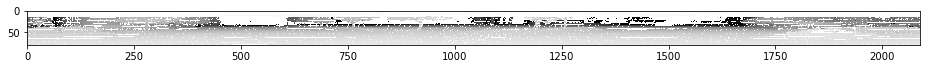

In [30]:
img_height = 80
img_width = 2088

# calculate histogram for inclination angle
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])
df_inclination_arr = df['inclination-angle'].as_matrix()
hist, bin_edges = np.histogram(df_inclination_arr, bins = img_height - 1)

df.sort_values(['rotation-angle'], inplace = True)

bin_size = 64

depth_img = np.zeros((img_width, img_height))

for i in range(img_width):
    df_rot_slice = df.iloc[bin_size * i : bin_size * (i + 1)].copy()
    df_rot_slice_arr = df_rot_slice['distance'].as_matrix()
    pixel_bin_arr = np.digitize(df_rot_slice['inclination-angle'], bin_edges)

    for j in range(len(pixel_bin_arr)):
        pixel_vert_loc = pixel_bin_arr[j] - 1
        depth_img[i][pixel_vert_loc] = df_rot_slice_arr[j]
    
depth_img = np.rot90(depth_img)

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'upper', vmax=50)

fig.savefig('depth-map.png', dpi = 300)

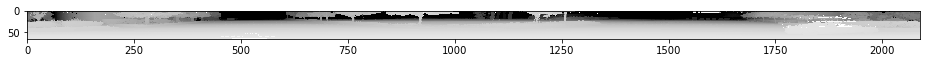

In [31]:
# Interpolation

mapping = {}
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, depth_img.shape[0] - nn_radius):
    for y in range(nn_radius, depth_img.shape[1] - nn_radius):
        # skip if not an empty pixel
        if (depth_img[x][y] != 0):
            continue
        
        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius
        
        # find out nearest neighbors' depths
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                pixel = depth_img[x_start + x_n][y_start + y_n]
                if (pixel != 0):
                    nn_arr.append(pixel)

        if (len(nn_arr) <= 1):
            if (x < img_height/2):
                mapping[(x, y)] = 100
            continue
        # fill empty pixel with average of filled in neighbors
        nn_avg = sum(nn_arr)/len(nn_arr)
        mapping[(x, y)] = nn_avg
        
for x, y in mapping:
    depth_img[x][y] = mapping[(x, y)]

# Cut off top of image
cut_off = 14
depth_img = depth_img[cut_off:][:]

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'upper', vmax=50)

fig.savefig('depth-map-vert.png', dpi = 300)

# Horizontal Binning

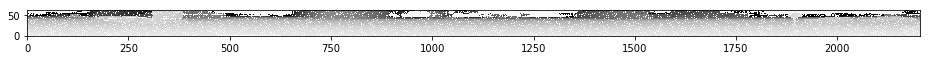

In [6]:
img_height = 64
img_width = 2204

laser_scan_pts = 2088


# Calculate inclination angle of each ring
df.sort_values(['ring'], inplace = True);

for i in range(img_height):
    df_laser_copy = df.iloc[img_width * i : img_width * (i + 1)].copy()
    laser_mean = df_laser_copy['inclination-angle'].mean()
    df.loc[df.index[laser_scan_pts * i : laser_scan_pts * (i + 1)], 
           'inclination-angle'] = laser_mean

    
# calculate histogram for rotation angle
df_rotation_arr = df['rotation-angle'].as_matrix()
hist, bin_edges = np.histogram(df_rotation_arr, bins = img_width - 1)

df.sort_values(['inclination-angle'], inplace = True)

bin_size = 2088

depth_img = np.zeros((img_height, img_width))

for i in range(img_height):
    df_rot_slice = df.iloc[bin_size * i : bin_size * (i + 1)].copy()
    df_rot_slice_arr = df_rot_slice['distance'].as_matrix()
    pixel_bin_arr = np.digitize(df_rot_slice['rotation-angle'], bin_edges)

    for j in range(len(pixel_bin_arr)):
        pixel_horiz_loc = pixel_bin_arr[j] - 1
        depth_img[i][pixel_horiz_loc] = df_rot_slice_arr[j]

        
fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'lower', vmax=50)

fig.savefig('depth-map.png', dpi = 300)

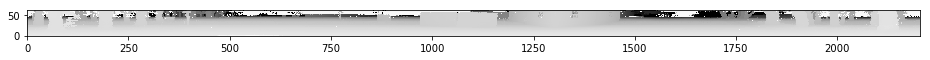

In [11]:
# Interpolation

mapping = {}
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, depth_img.shape[0] - nn_radius):
    for y in range(nn_radius, depth_img.shape[1] - nn_radius):
        # find all empty pixels
        if (depth_img[x][y] != 0):
            continue
        
        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius
        
        # find out nearest neighbors' depths
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                pixel = depth_img[x_start + x_n][y_start + y_n]
                if (pixel != 0):
                    nn_arr.append(pixel)

        next_nn_radius = nn_radius
        while (len(nn_arr) == 0):
            next_nn_radius += 1;
            x_start = x - next_nn_radius
            y_start = y - next_nn_radius
            
            if (x_start < 0):
                x_start = 0
            if (y_start < 0):
                y_start = 0

            # find out nearest neighbors' depths
            for x_n in range(2 * next_nn_radius + 1):
                for y_n in range(2 * next_nn_radius + 1):
                    if (x_start + x_n >= depth_img.shape[0]):
                        continue
                    if (y_start + y_n >= depth_img.shape[1]):
                        continue
                    pixel = depth_img[x_start + x_n][y_start + y_n]
                    if (pixel != 0):
                        nn_arr.append(pixel)
        
        if (len(nn_arr) <= 2):
            if (x < img_height/2):
                mapping[(x, y)] = 100
            continue
        # fill empty pixel with average of filled in neighbors
        nn_avg = sum(nn_arr)/len(nn_arr)
        mapping[(x, y)] = nn_avg
        
for x, y in mapping:
    depth_img[x][y] = mapping[(x, y)]

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'lower', vmax=50)

fig.savefig('depth-map-horiz.png', dpi = 300)